In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
from lib_merging import *
import mysql.connector


In [2]:

user='spirz'
password='this_is_my_PASSWORD_m8'
host='localhost'
database='dem_from_contours_lines'
contours_lines_table_name='contours_lines'
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"


2

2

In [3]:
DBM=DataBaseManager(user=user,password=password,host=host,database=database,
            contours_lines_table_name=contours_lines_table_name,
            osm_nodes_table_name=osm_nodes_table_name,
            osm_edges_table_name=osm_edges_table_name,
            intersections_table_name=intersections_table_name)
2

2

In [4]:
level=1000
t1=time.time()
level_open_contours_df=DBM.get_level_contours_df(level,is_closed=False)
crs=level_open_contours_df.estimate_utm_crs()
level_open_contours_df=level_open_contours_df.to_crs(crs)
t2=time.time()
print(t2-t1)
level_open_contours_df

1.3143069744110107


,id,is_closed,elevation,geometry
id,,,,
1678,1678,0,1000.0,"LINESTRING (506479.812 4704061.394, 506492.412..."
3661,3661,0,1000.0,"LINESTRING (526201.064 4688949.731, 526199.609..."
4394,4394,0,1000.0,"LINESTRING (538954.881 4687974.154, 538952.566..."
4994,4994,0,1000.0,"LINESTRING (506112.096 4699235.718, 506119.045..."
5455,5455,0,1000.0,"LINESTRING (505542.558 4691761.033, 505544.523..."
...,...,...,...,...
90485,90485,0,1000.0,"LINESTRING (497050.484 4651146.269, 497038.763..."
92287,92287,0,1000.0,"LINESTRING (500229.872 4622009.075, 500226.533..."
93342,93342,0,1000.0,"LINESTRING (500866.327 4650855.809, 500870.055..."


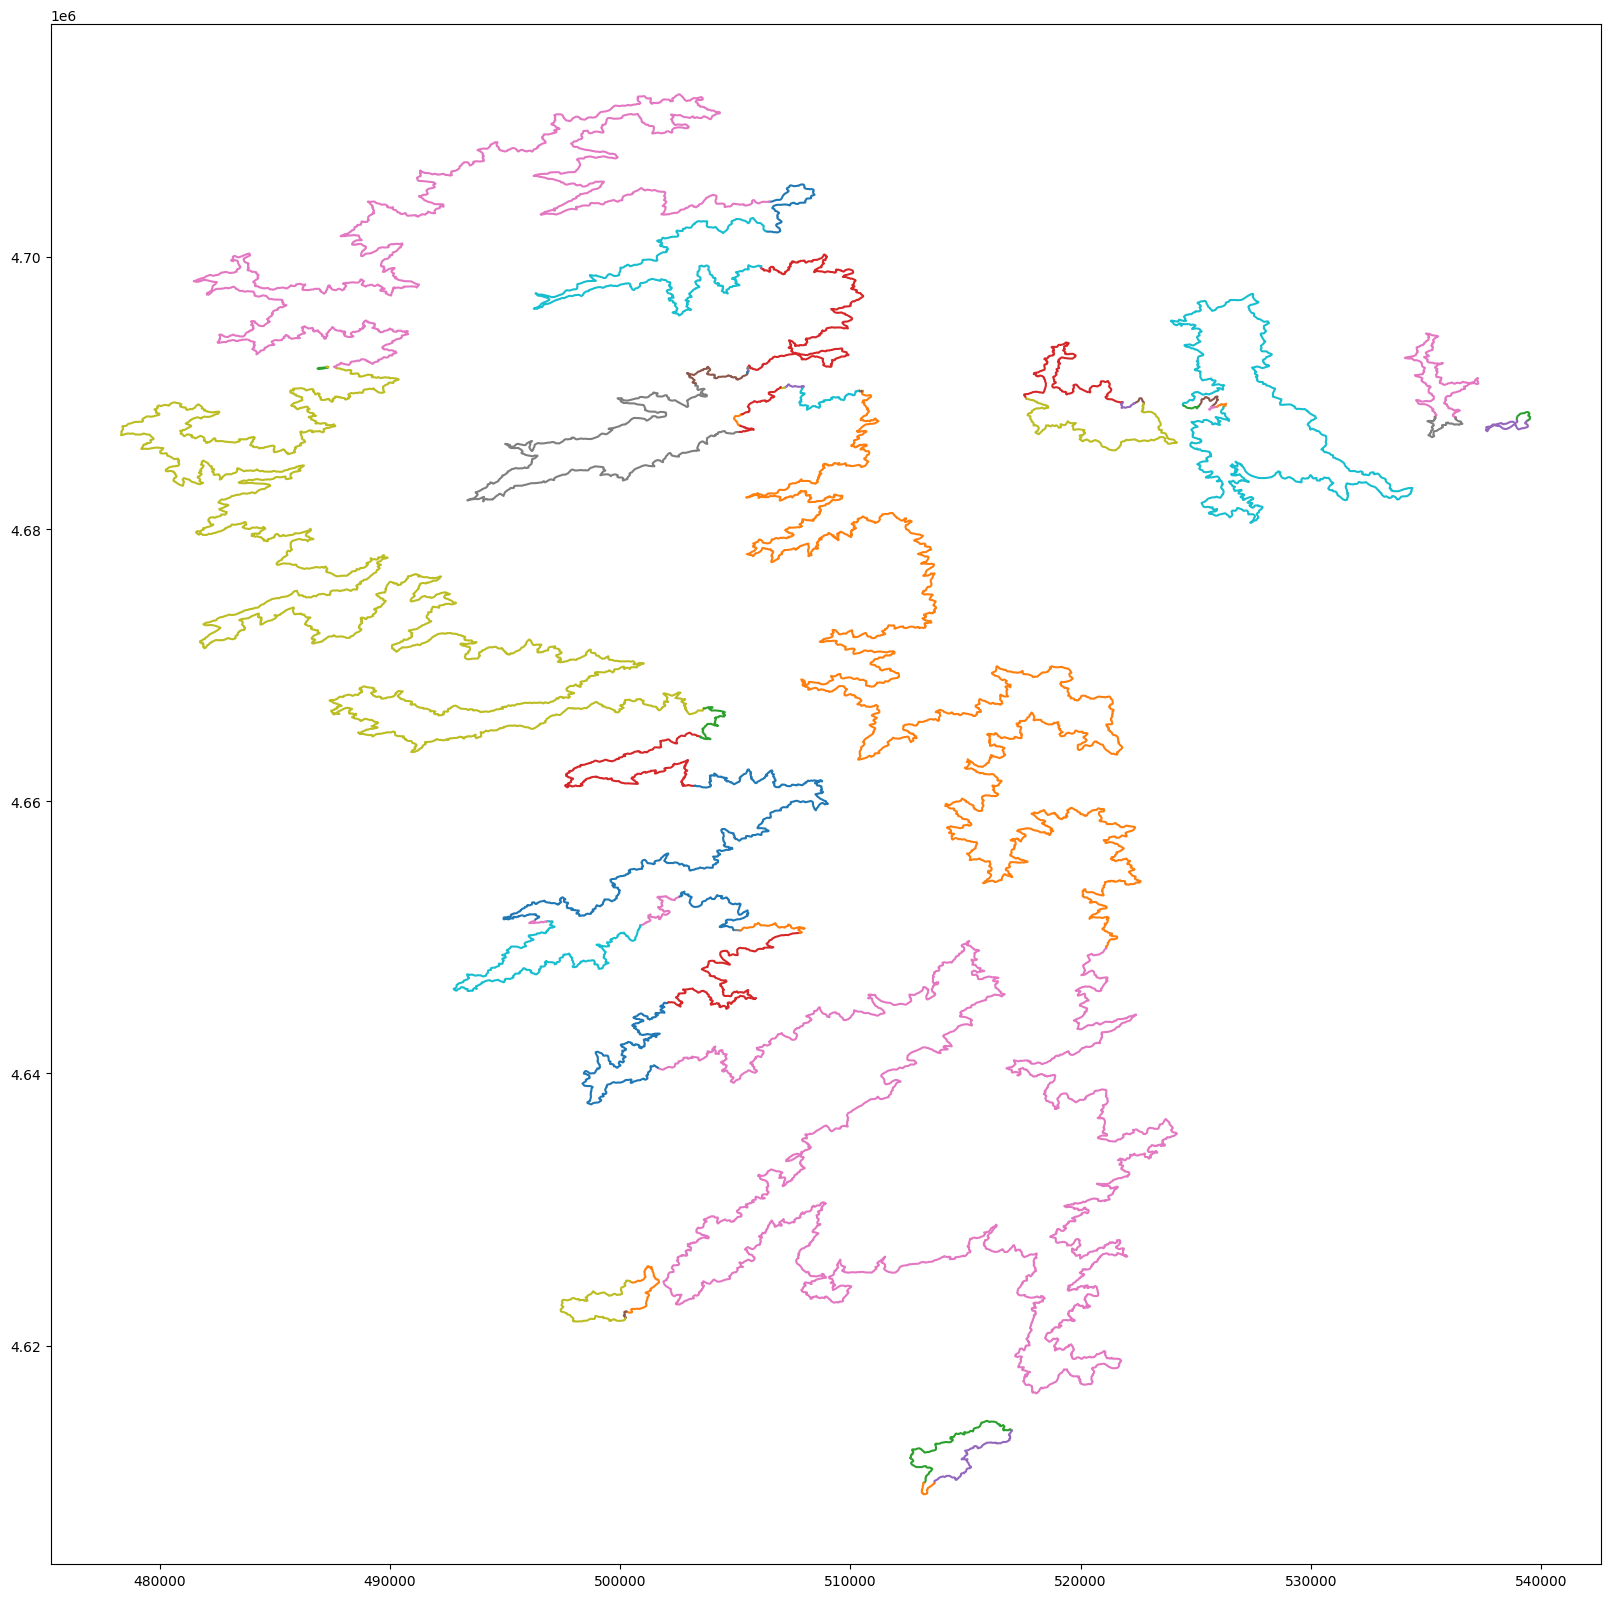

In [5]:
plt.rcParams['figure.figsize']=(20,20)

for ls in level_open_contours_df['geometry']:
    coords=np.array(ls.coords)
    plt.plot(coords[:,0],coords[:,1])


0.7385115623474121


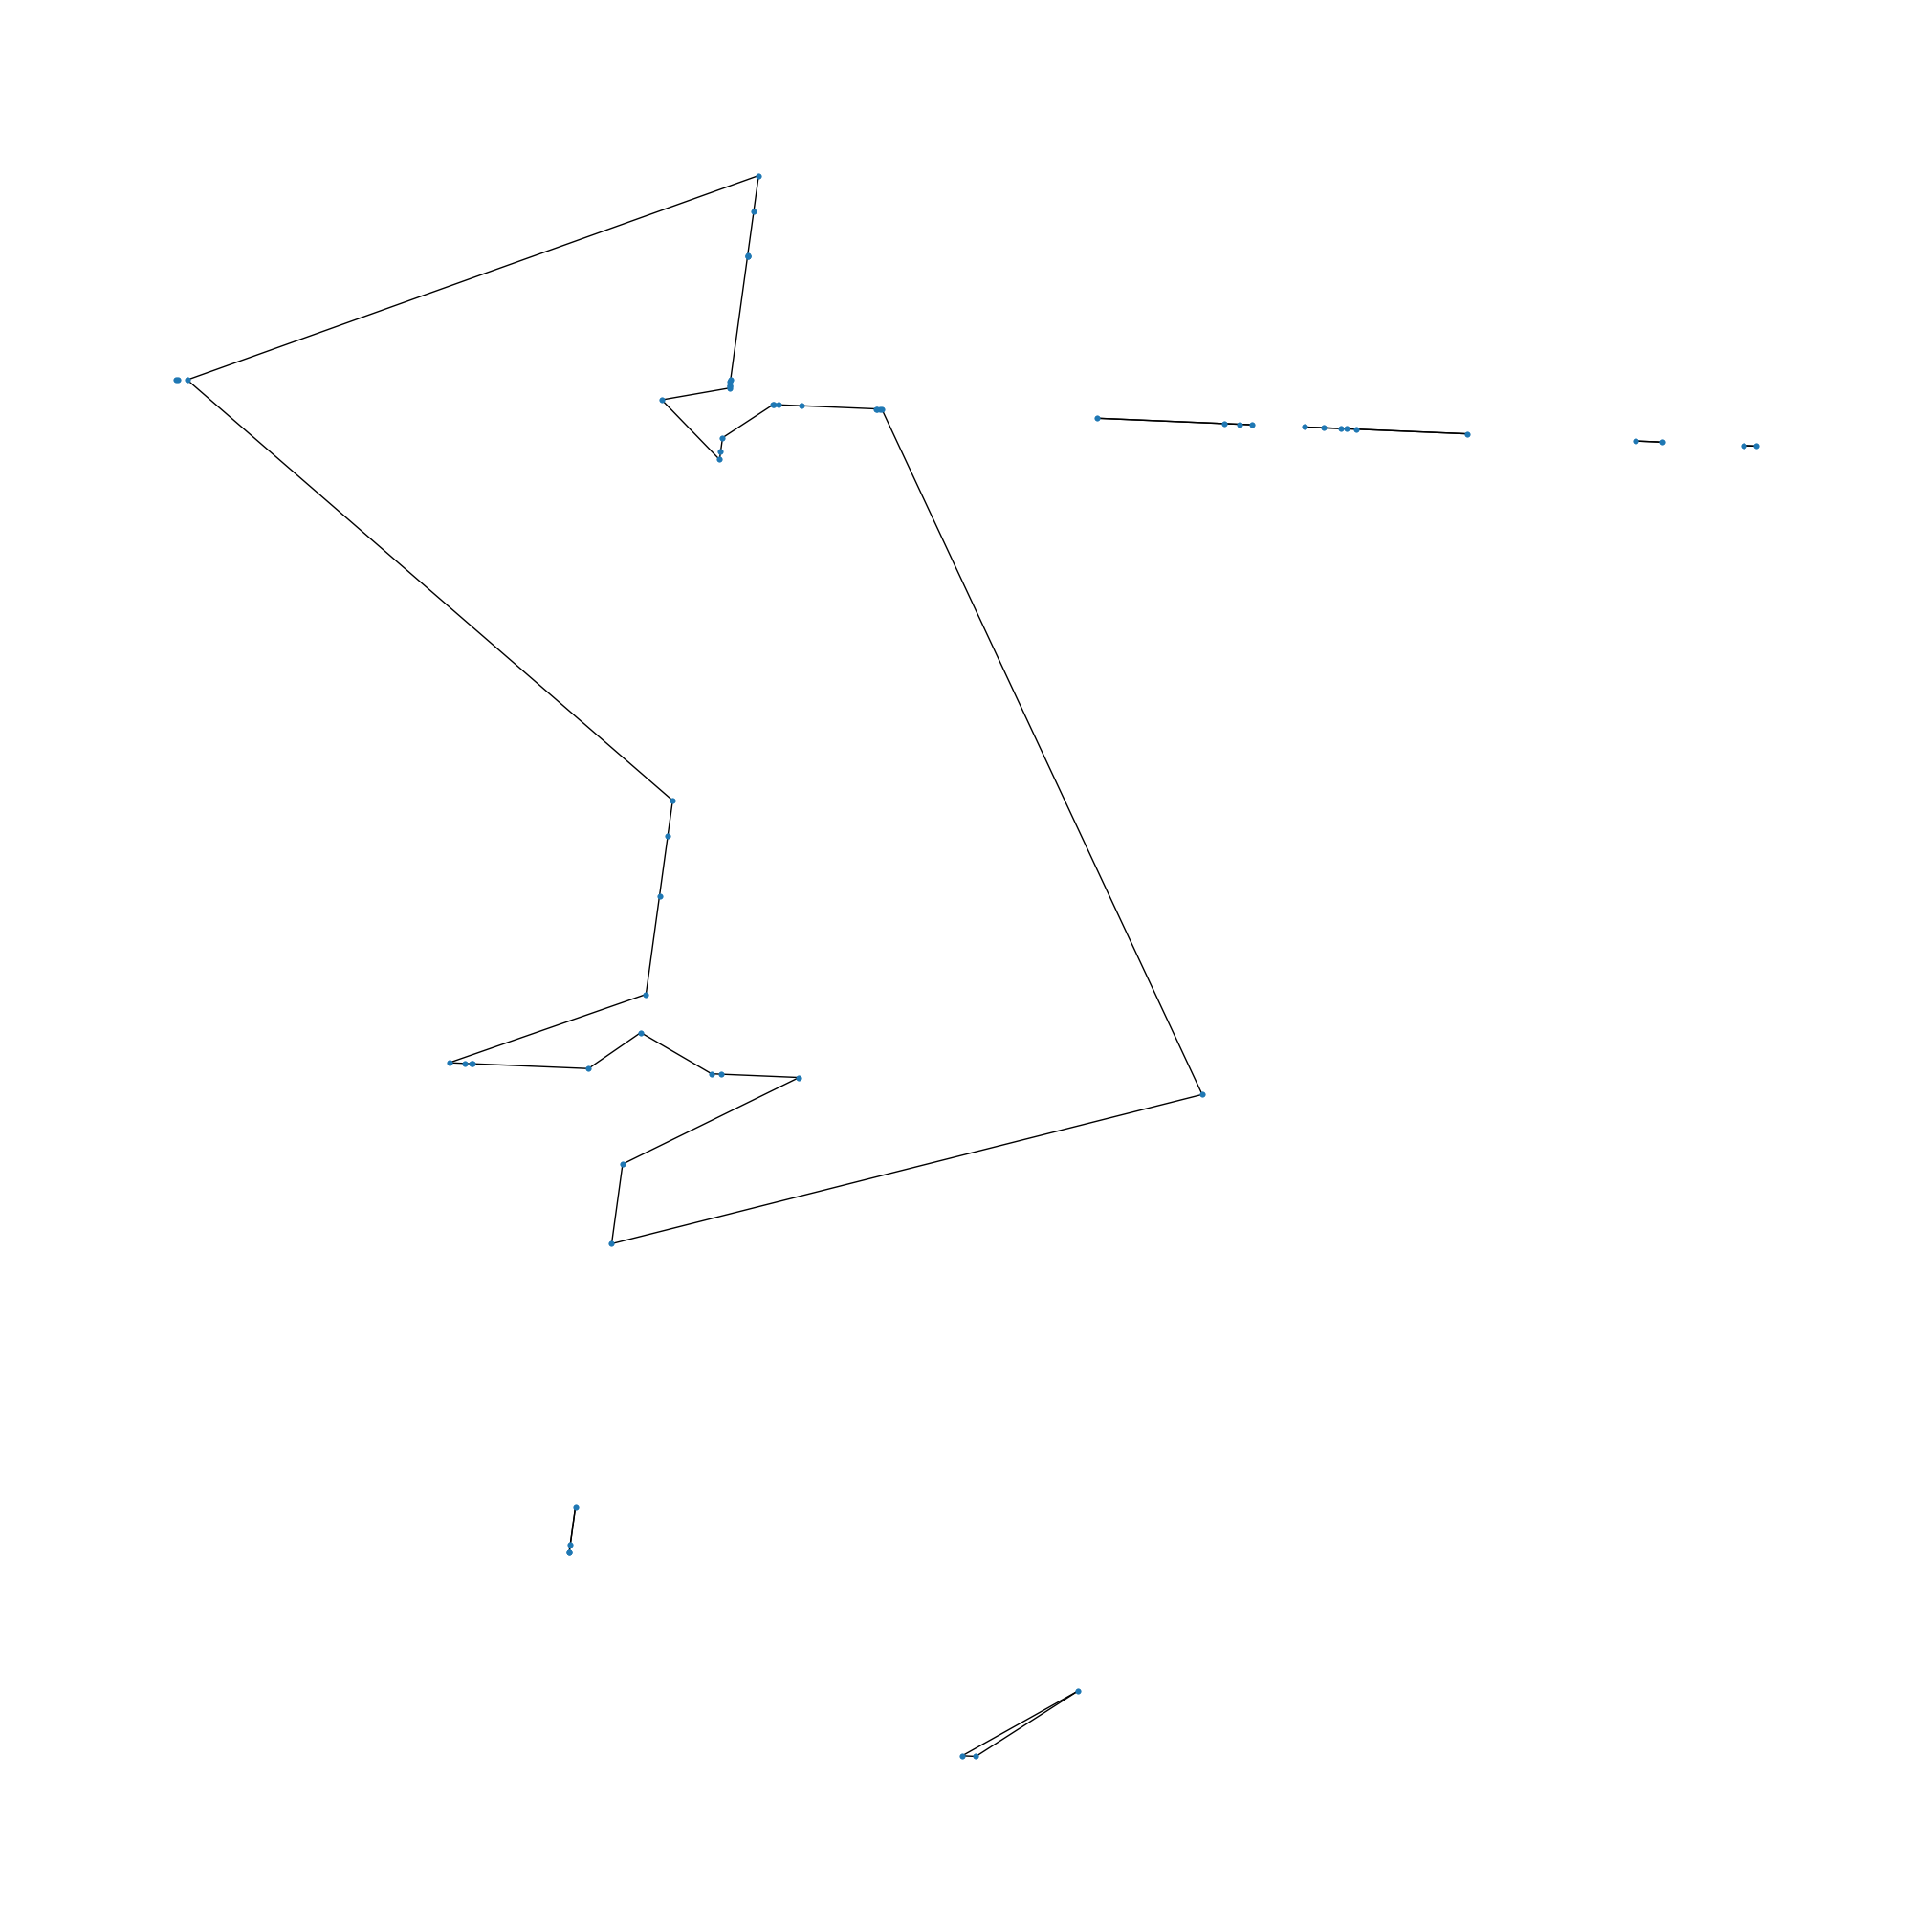

In [6]:
t1=time.time()
G_extremities=build_open_contour_graph(level_open_contours_df,max_distance=1)
t2=time.time()
print(t2-t1)
pos=pos={node:(data['x'],data['y']) for node,data in G_extremities.nodes(data=True)}
nx.draw(G_extremities,pos=pos,node_size=10)

In [7]:
len(list(nx.connected_components(G_extremities)))

8

0.033368587493896484


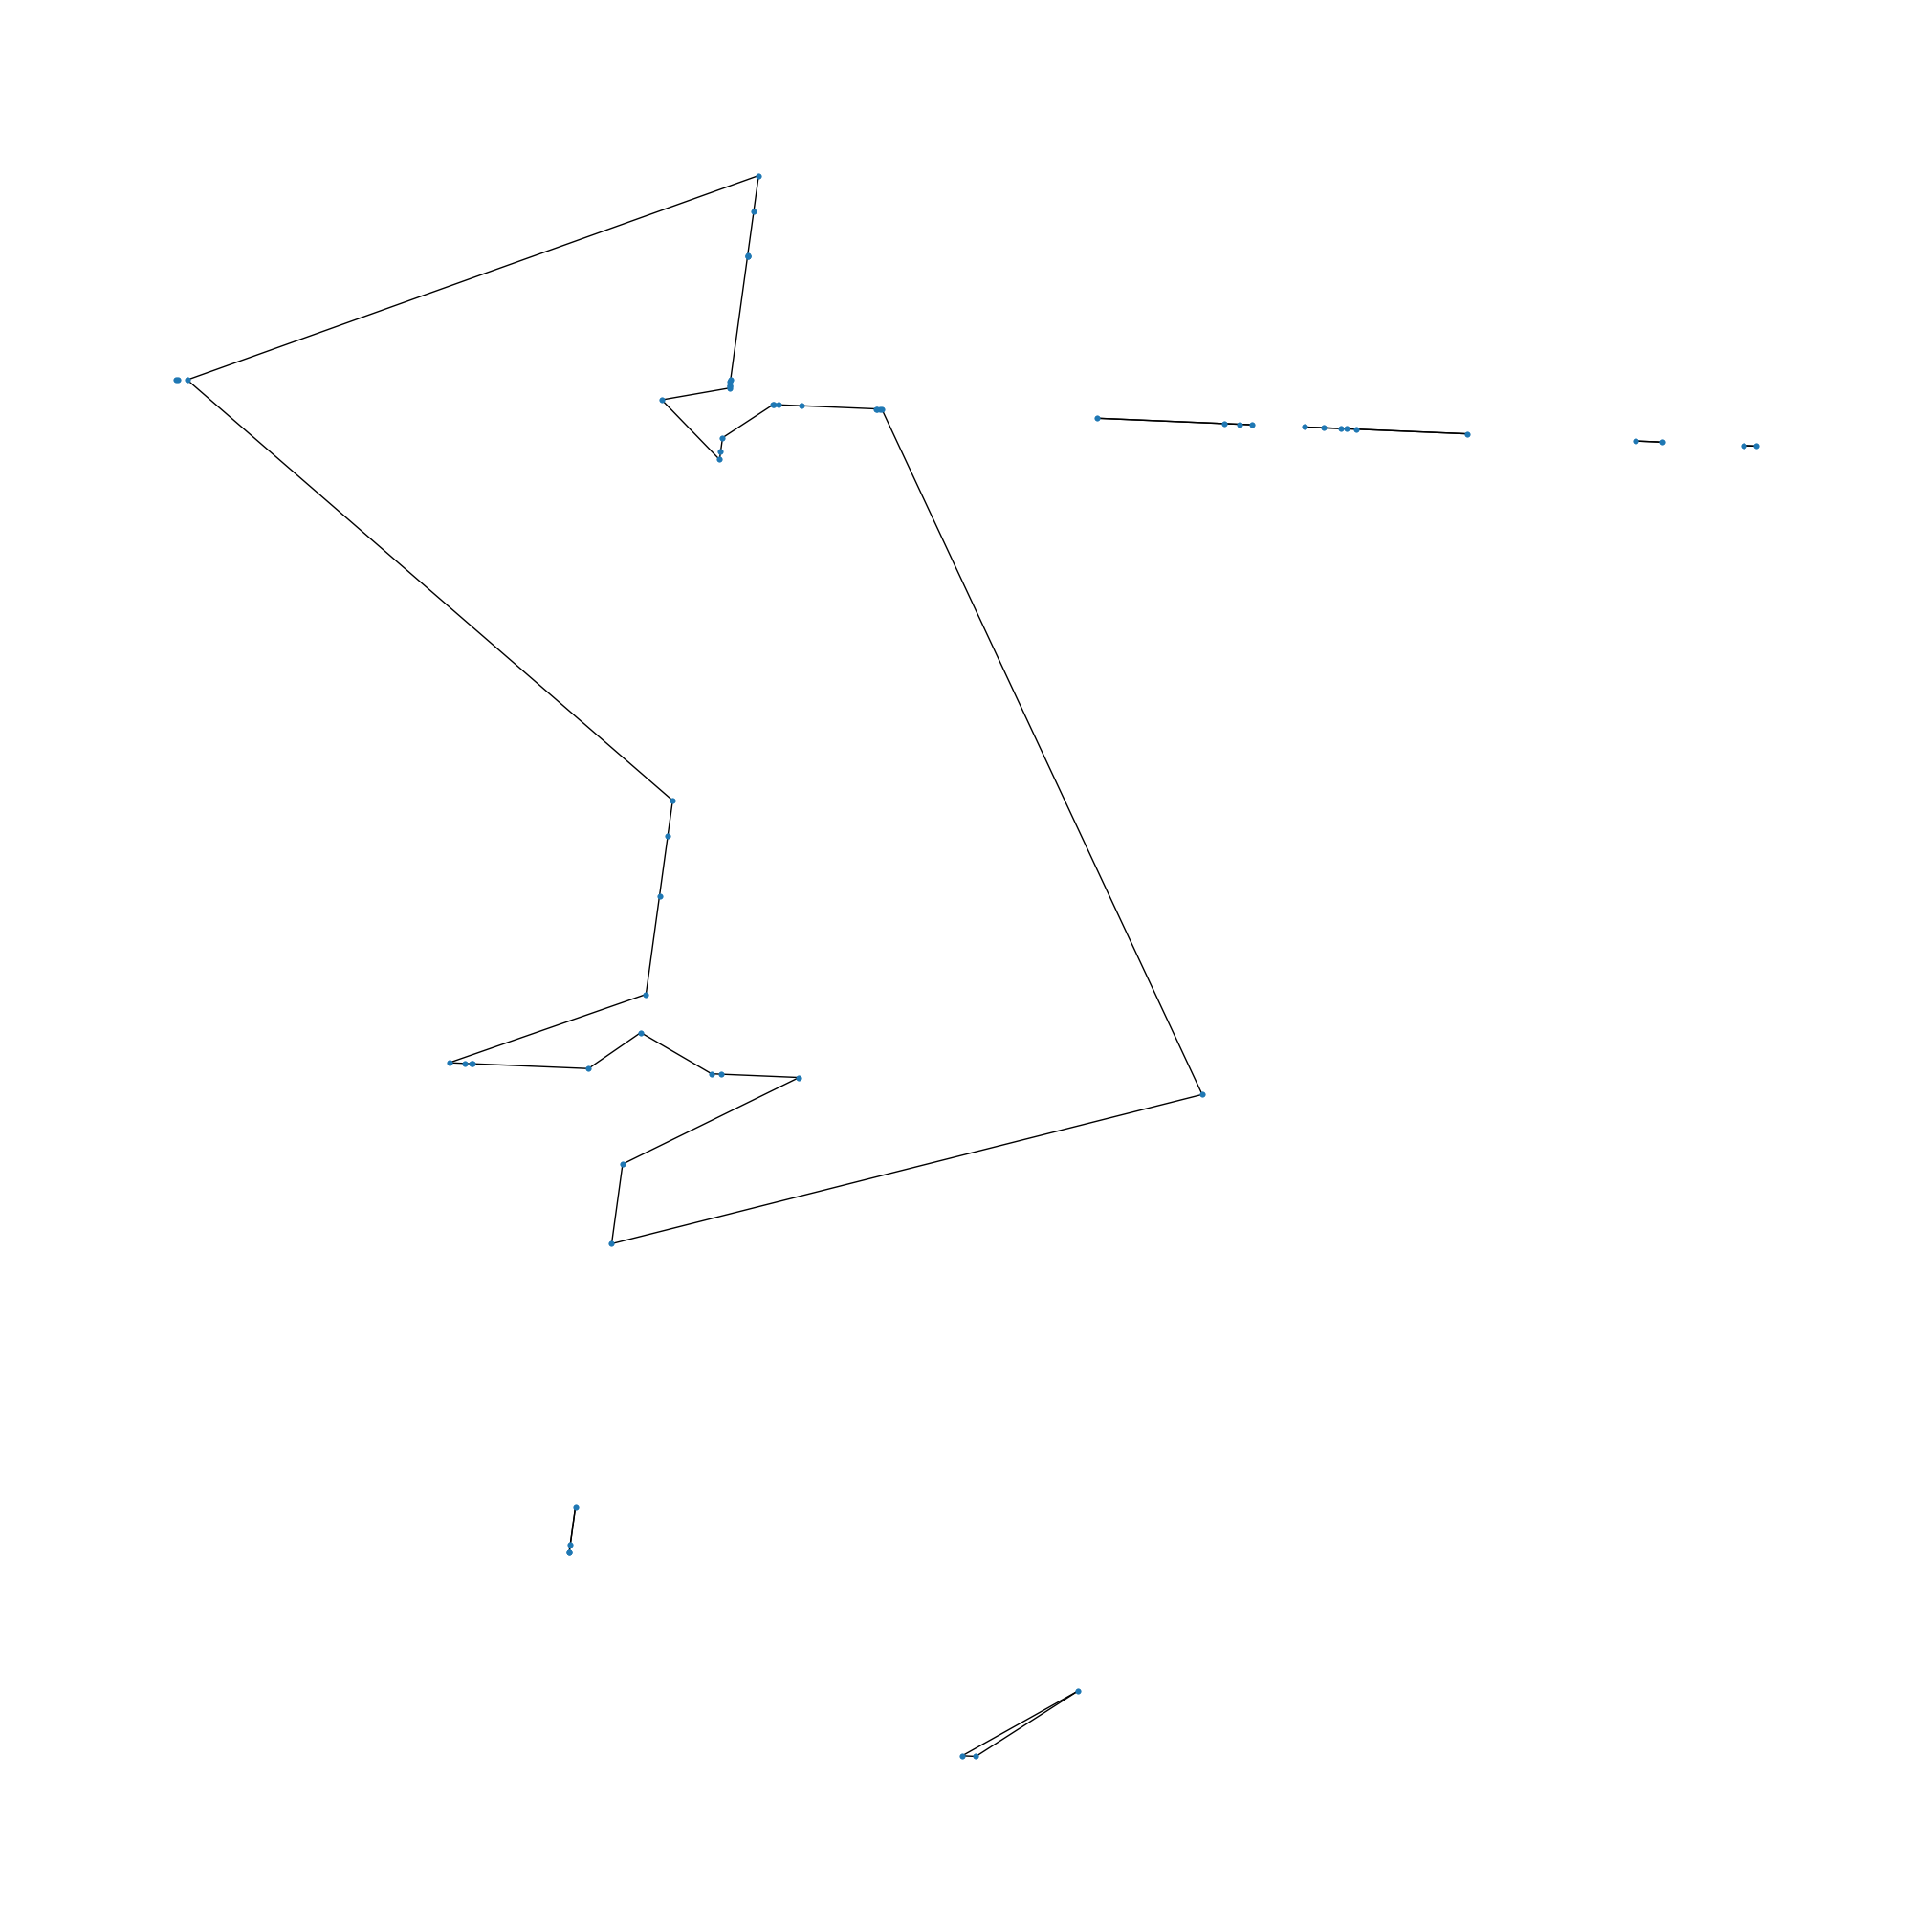

In [8]:
t1=time.time()
clean_graph(G_extremities)
remove_branch(G_extremities)

t2=time.time()
print(t2-t1)
nx.draw(G_extremities,pos=pos,node_size=10)

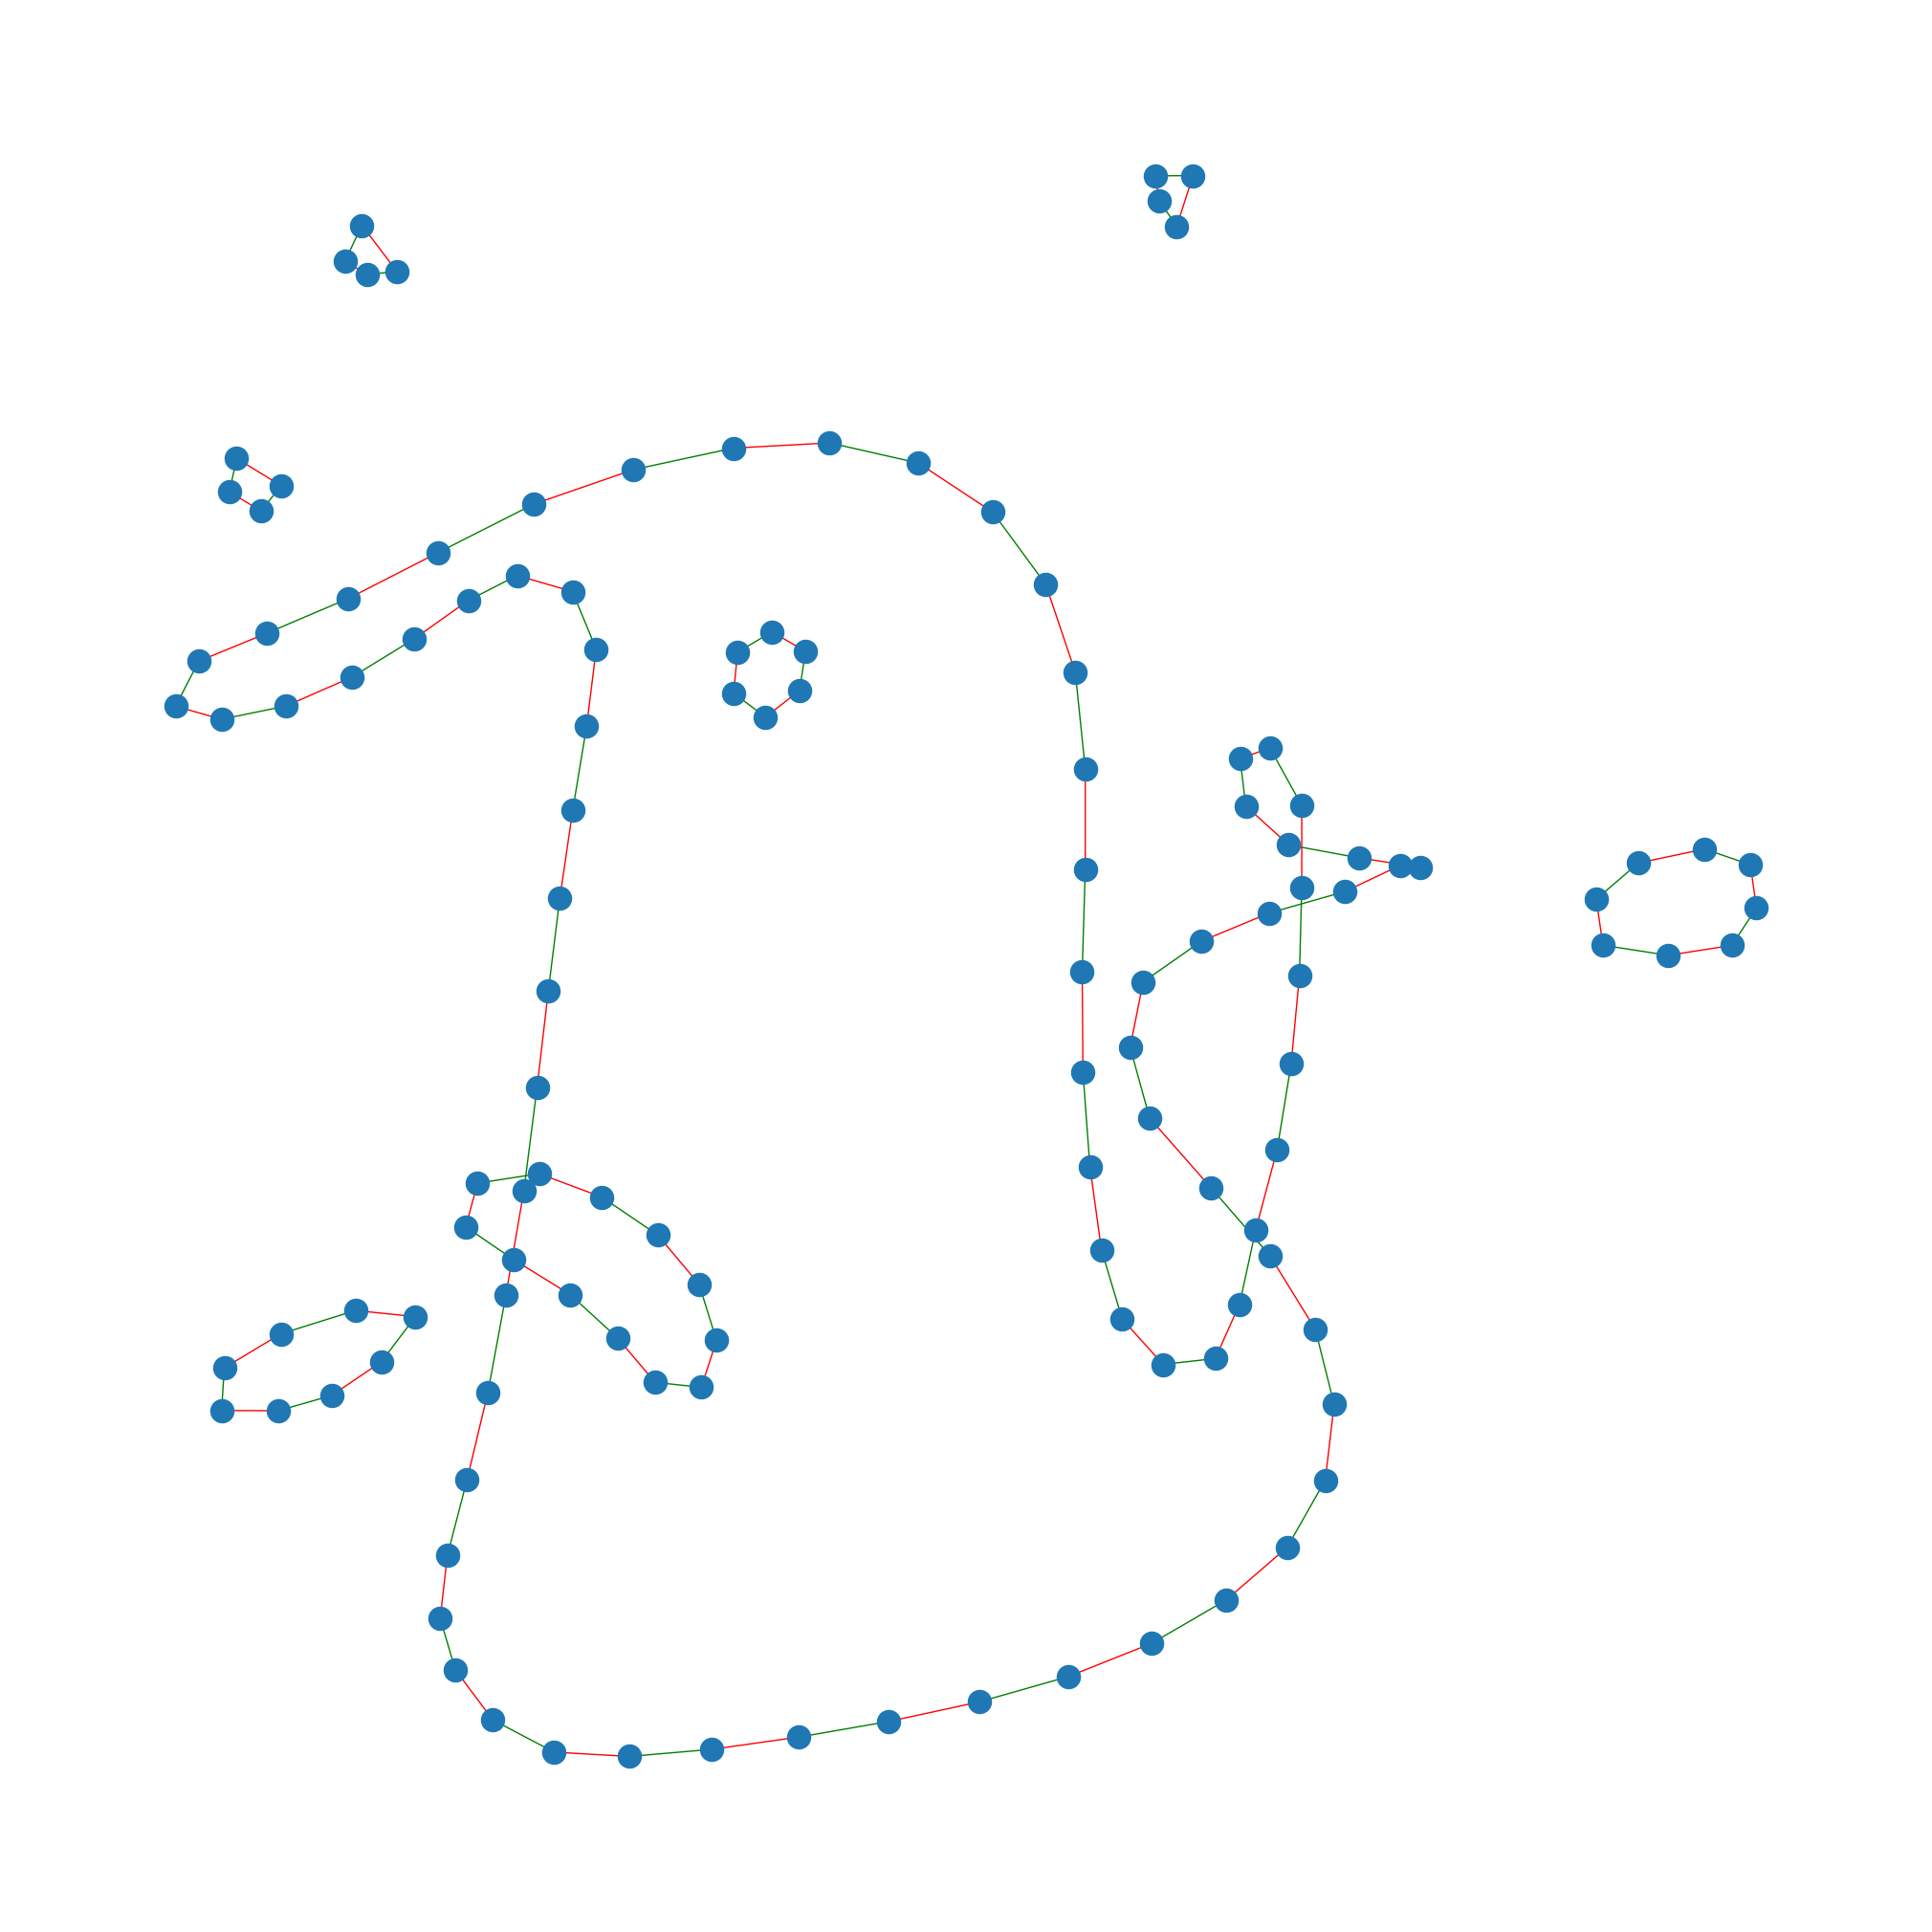

In [9]:
cycles,paths=cycle_chain_decomposition(G_extremities)

cycle_edges=[(cycle[i],cycle[i+1]) for cycle in cycles for i in range(len(cycle)-1)]
path_edges=cycle_edges+[(path[i],path[i+1]) for path in paths for i in range(len(path)-1)]
edge_color=[]
for u,v in G_extremities.edges():
    if (u,v) in path_edges or (v,u) in path_edges:
        if G_extremities.get_edge_data(u,v)['edge_type']=='contour':
            edge_color.append('r')
        else:
            edge_color.append('g')
    else:
        edge_color.append('k')
nx.draw(G_extremities,edge_color=edge_color)

1.1257750988006592


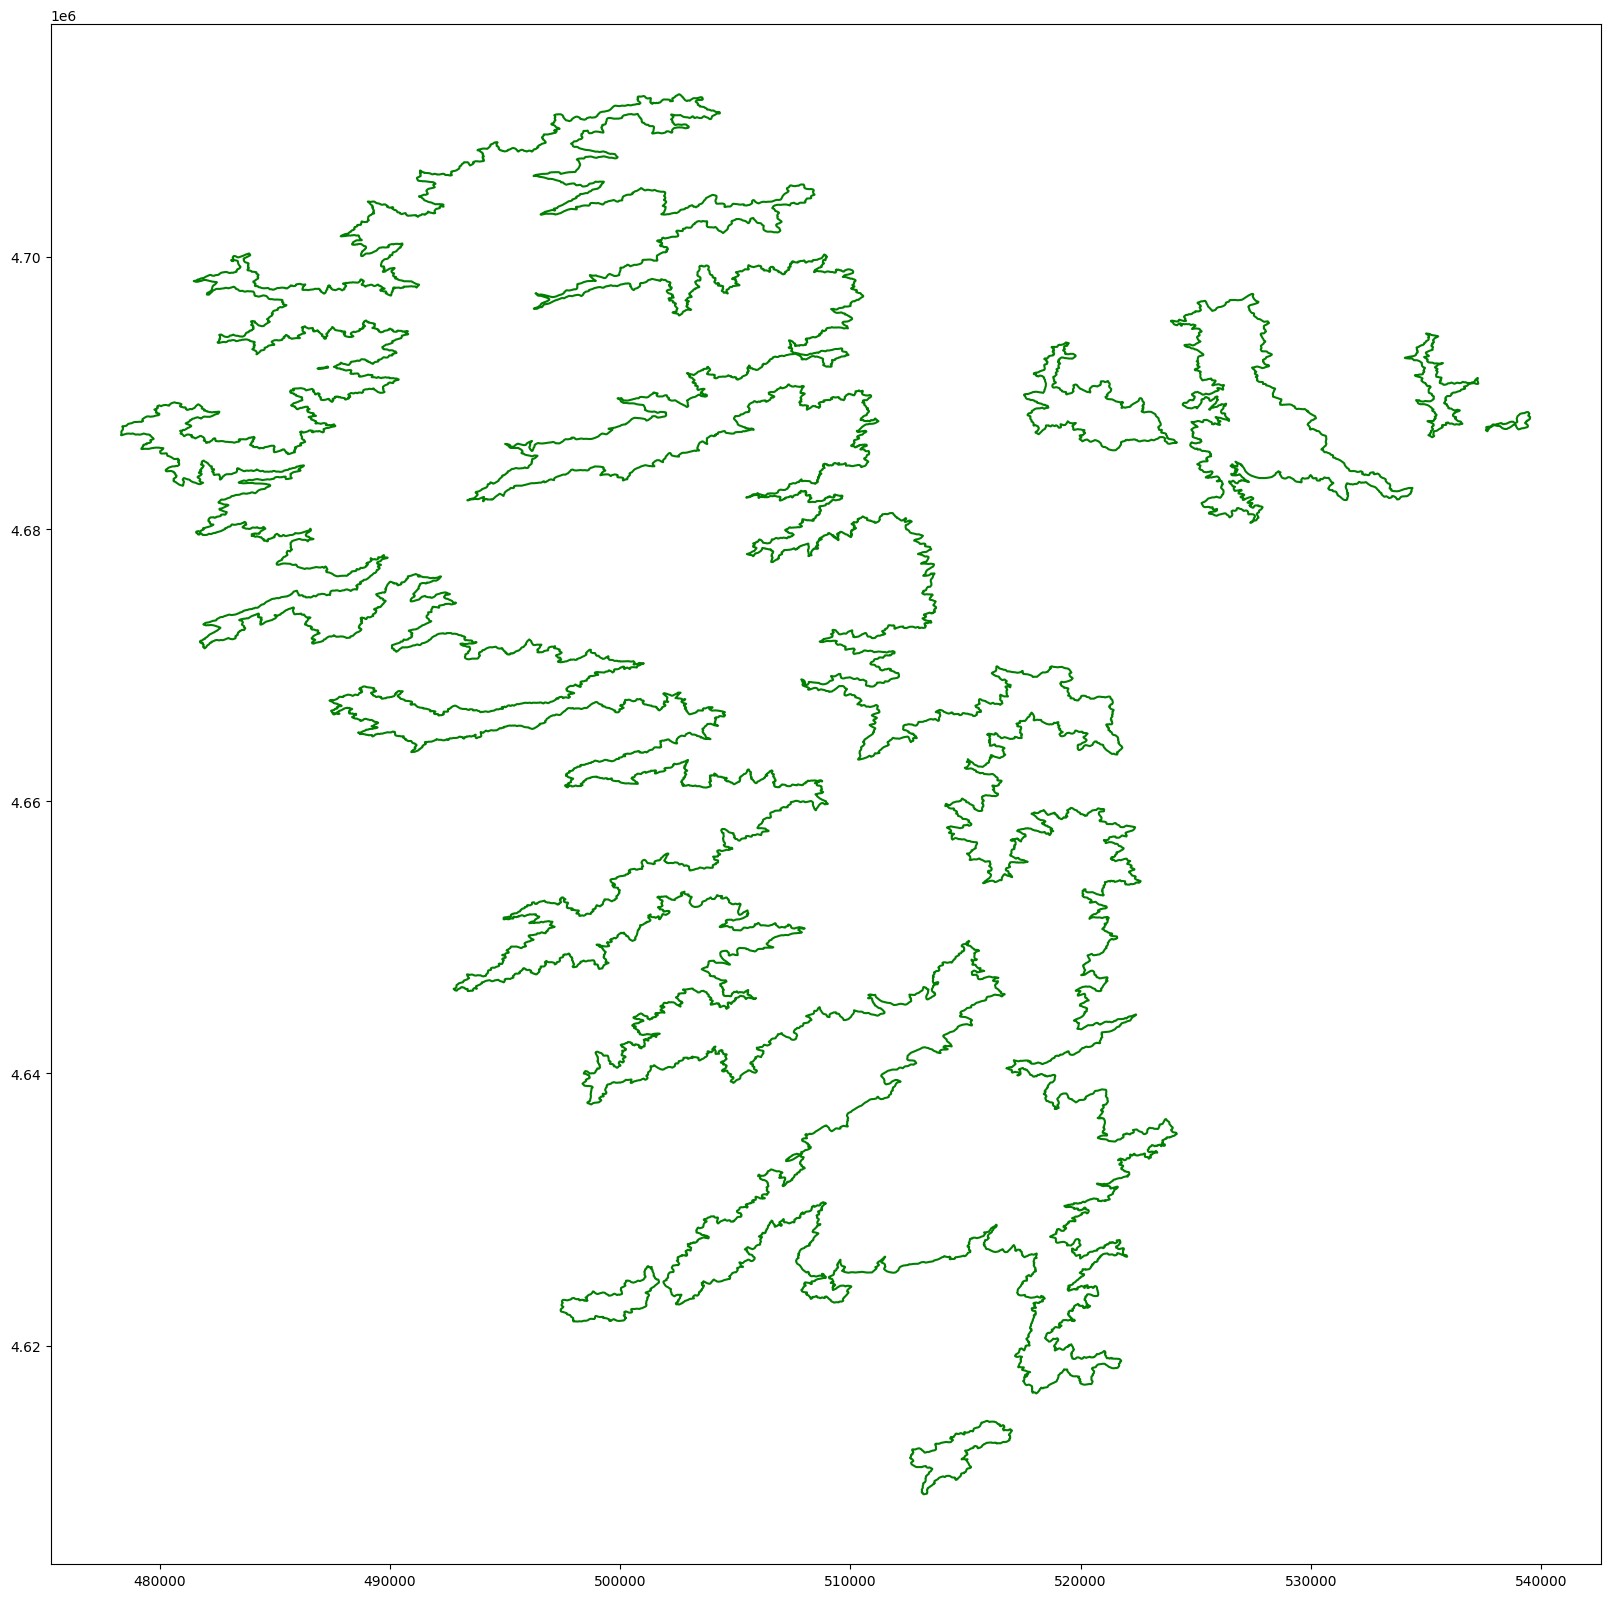

In [10]:
plt.rcParams['figure.figsize']=(20,20)
t1=time.time()
closed_contour_lines,open_contour_lines,merged_nodes=get_contour_lines_from_elevation_df(level_open_contours_df,max_distance=10)
t2=time.time()
print(t2-t1)
for ls in closed_contour_lines:
    coords=np.array(ls.coords)
    plt.plot(coords[:,0],coords[:,1],c='g')
for ls in open_contour_lines:
    coords=np.array(ls.coords)
    plt.plot(coords[:,0],coords[:,1],c='r')
